In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
np.random.seed(42)

2021-10-24 04:01:38.032282: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-24 04:01:38.032407: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Reading data and concatenating data for exploration
train = pd.read_csv('../input/bappracticemodule/train1020.csv')
test = pd.read_csv('../input/bappracticemodule/test1020.csv')
courses = pd.concat([train, test], ignore_index=False)

array([[<AxesSubplot:title={'center':'ranking'}>,
        <AxesSubplot:title={'center':'hours_to_complete'}>],
       [<AxesSubplot:title={'center':'num_subtitles'}>,
        <AxesSubplot:title={'center':'subscribers'}>],
       [<AxesSubplot:title={'center':'log_subscribers'}>, <AxesSubplot:>]],
      dtype=object)

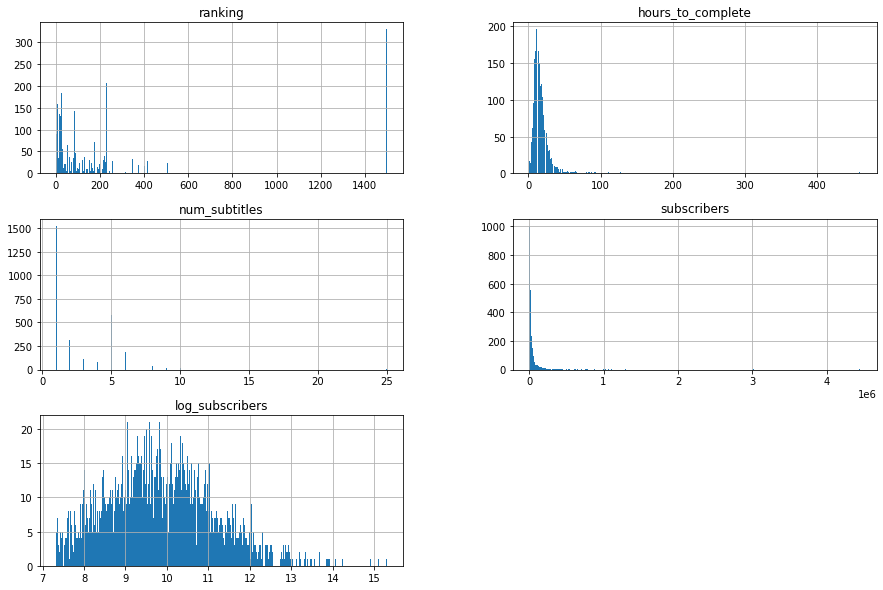

In [3]:
# Checking the whole dataset
courses.hist(figsize=(15, 10),bins=500)

array([[<AxesSubplot:title={'center':'ranking'}>,
        <AxesSubplot:title={'center':'hours_to_complete'}>],
       [<AxesSubplot:title={'center':'num_subtitles'}>,
        <AxesSubplot:title={'center':'subscribers'}>],
       [<AxesSubplot:title={'center':'log_subscribers'}>, <AxesSubplot:>]],
      dtype=object)

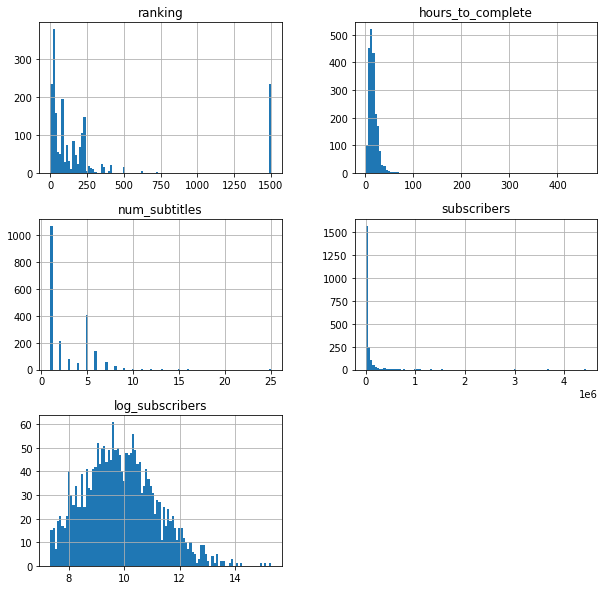

In [4]:
# Checking the training set
train.hist(figsize=(10, 10),bins=100)

In [5]:
# Dropping unnecessary columns
train.drop(columns=['title', 'description', 'link', 'provider', 'provider_category', 'category'], inplace=True )
test.drop(columns=['title', 'description', 'link', 'provider','provider_category', 'category'], inplace=True )

In [6]:
# Defining a mapping dict for ordinal encoding of 'level' column
course_level_dict = {'Unknown Level': 0, 'Beginner Level': 1, 'Intermediate Level': 2, 'Advanced Level': 3}

# Mapping the dict to perform ordinal encoding
train['level'] = train['level'].map(course_level_dict)
test['level'] = test['level'].map(course_level_dict)

In [7]:
# Using Target encoding for 'subcategory' column
encoder = TargetEncoder()
train['subcategory_encoded'] = encoder.fit_transform(train['subcategory'], train['log_subscribers'])
target_encoding_dict = dict(train.groupby('subcategory')['subcategory_encoded'].mean())
test['subcategory_encoded'] = test['subcategory'].map(target_encoding_dict)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [8]:
# Mapping the target encoding dict to test set
test['subcategory_encoded'] = test['subcategory'].map(target_encoding_dict)

In [9]:
# Dropping uncessary columns and splitting target variables
X_train = train.drop(columns=['subcategory', 'subscribers']).copy()
Y_train = X_train.pop('log_subscribers')
X_test = test.drop(columns=['subcategory', 'subscribers']).copy()
Y_test = X_test.pop('log_subscribers')

In [10]:
# Peforming normalization
normalizer = Normalizer()
normalized_X_train = normalizer.fit_transform(X_train)
normalized_X_test = normalizer.transform(X_test)

In [11]:
# Initializing the model
NN_model = Sequential()

# The Input Layer:
NN_model.add(layers.Dense(64, 
                          kernel_initializer='normal', 
                          input_dim = normalized_X_train.shape[1], 
                          activation='relu'))

# The Hidden Layers :
NN_model.add(layers.Dense(128, kernel_initializer='normal', activation='relu'))
NN_model.add(layers.Dense(128, kernel_initializer='normal', activation='relu'))
NN_model.add(layers.Dense(128, kernel_initializer='normal', activation='relu'))
NN_model.add(layers.Dense(128, kernel_initializer='normal', activation='relu'))
NN_model.add(layers.Dense(128, kernel_initializer='normal', activation='relu'))
NN_model.add(layers.Dense(128, kernel_initializer='normal', activation='relu'))
NN_model.add(layers.Dense(128, kernel_initializer='normal', activation='relu'))

# The Output Layer:
NN_model.add(layers.Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network:
NN_model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
NN_model.summary()

2021-10-24 04:01:53.224806: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-24 04:01:53.228020: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-24 04:01:53.228059: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-24 04:01:53.228086: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fbbb37e2b7f8): /proc/driver/nvidia/version does not exist
2021-10-24 04:01:53.228422: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [12]:
# Defining a callback to track the training process by printing dots
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Using "early stop" to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [13]:
# Defining a function to visualize the results
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.ylim([0, 3])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

2021-10-24 04:01:53.850686: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-24 04:01:53.865236: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz



.....................................................................................

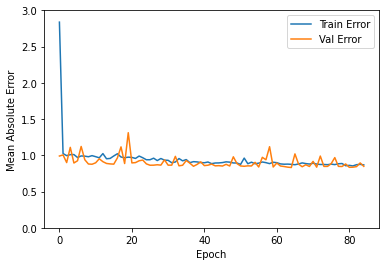

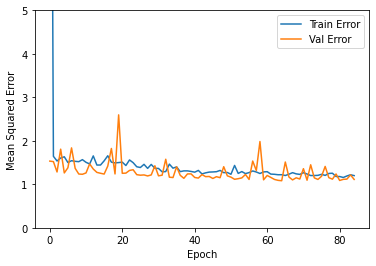

In [14]:
# Training the model with batch gradient descent
history = NN_model.fit(normalized_X_train, Y_train, epochs=1000, batch_size=16,
                       validation_data=(normalized_X_test, Y_test), verbose=0, 
                       callbacks=[early_stop, PrintDot()],)
plot_history(history)

In [15]:
print('Training MAE:', history.history['mae'][-1])
print('Training RMSE:', np.sqrt(history.history['mse'][-1]))
print('\n')
print('Validation MAE:', history.history['val_mae'][-1])
print('Validation RMSE:', np.sqrt(history.history['val_mse'][-1]))

Training MAE: 0.8680621385574341
Training RMSE: 1.09545667191957


Validation MAE: 0.8479514718055725
Validation RMSE: 1.0546815660097826


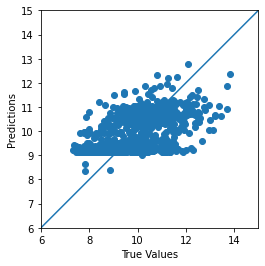

In [16]:
# Predicted values vs. true values (logarithmic)
Y_predictions = NN_model.predict(normalized_X_test).flatten()

plt.scatter(Y_test, Y_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([6, 15])
plt.ylim([6, 15])
_ = plt.plot([-20, 20], [-20, 20])

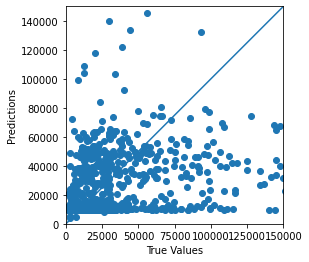

In [17]:
# Converting back to the original values
plt.scatter(np.exp(Y_test), np.exp(Y_predictions))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 150000])
plt.ylim([0, 150000])
_ = plt.plot([-300000, 300000], [-300000, 300000])

In [18]:
NN_model.save('saved_model')

2021-10-24 04:02:26.766987: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
